<a href="https://colab.research.google.com/github/abhisriv-466/Similarity_Learning/blob/main/Similarity_Learning_using_SNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split

In [ ]:
# Importing the Dataset

import numpy as np
from sklearn.datasets import fetch_olivetti_faces

# Import the sklearn olivetti faces dataset
data = fetch_olivetti_faces()
images = data.images
labels = data.target

In [ ]:
target_shape=images[0].shape

In [ ]:
inputs = layers.Input((64, 64, 1))

x = layers.Conv2D(64, (10, 10), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (7, 7), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (4, 4), padding="same", activation="relu")(x)
fcOutput = layers.Flatten()(x)
fcOutput = layers.Dense(4096, activation = "relu")(fcOutput)
outputs = layers.Dense(1024, activation = "sigmoid")(fcOutput)

embedding = Model(inputs, outputs, name = "Embedding")

In [ ]:
import tensorflow.keras.backend as K

In [ ]:
# Distance Layer
class DistanceLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [ ]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (1,))
compare_input = layers.Input(name="compare", shape=target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),
)

outputs = layers.Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)

In [ ]:
# Generating the positive pairs

Positive_images = []
index = 0

for i in range(40):
  # taking the similar faces and append that to this Positive_images
  temp = []
  temp.append(images[index])
  temp.append(images[index+1])
  Positive_images.append(temp)

  # doing the same task again for another pair
  temp = []
  temp.append(images[index+2])
  temp.append(images[index+3])
  Positive_images.append(temp)

  # shifting the index to move to next person
  index = index+10



# Generating the negative pairs

Negative_images=[]

index = 0

for i in range(39):
  # collecting the images of next-to-next diff person and appending it to Negative_pairs
  temp = []
  temp.append(images[index])
  temp.append(images[index+10])
  Negative_images.append(temp)

  # Another one of them
  temp = []
  temp.append(images[index+1])
  temp.append(images[index+11])
  Negative_images.append(temp)

  # shifting to next pairs
  index = index+10

In [ ]:
images[0].shape

(64, 64)

In [ ]:
labels.shape

(400,)

In [ ]:
labels[1]

0

### **Notice that Negative pairs are one less in number** *(Nothing wrong in that)*

In [ ]:
Positive_images = np.array(Positive_images)
print("shape of Positive_images:", Positive_images.shape)

Negative_images = np.array(Negative_images)
print("shape of Negative_images:", Negative_images.shape)

shape of Positive_images: (80, 2, 64, 64)
shape of Negative_images: (78, 2, 64, 64)


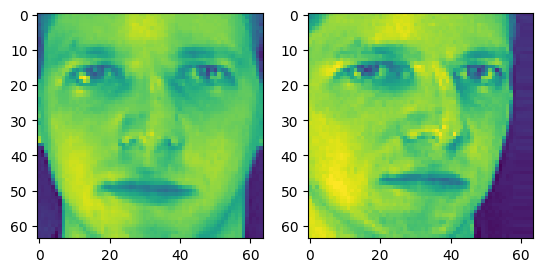

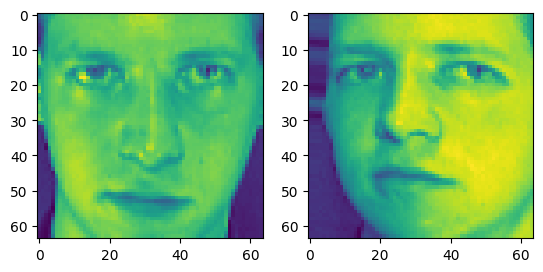

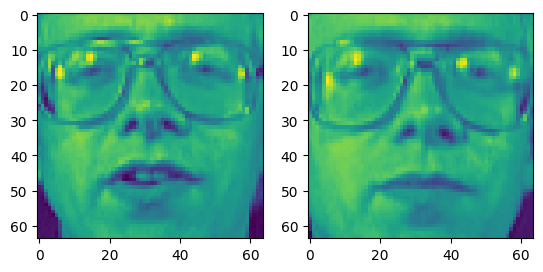

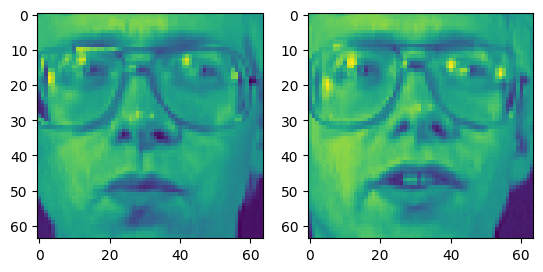

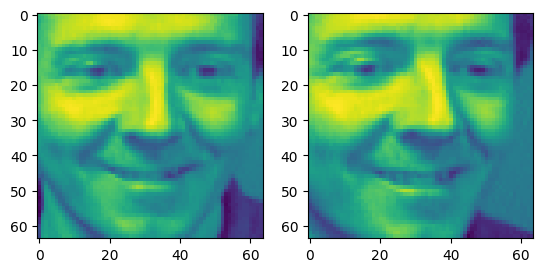

In [ ]:
import matplotlib.pyplot as plt

# plotting the positive pairs
for i in range(5):
  plt.subplot(1,2,1)
  plt.imshow(Positive_images[i][0])
  plt.subplot(1,2,2)
  plt.imshow(Positive_images[i][1])
  plt.show()

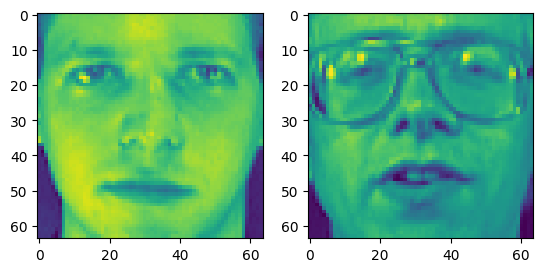

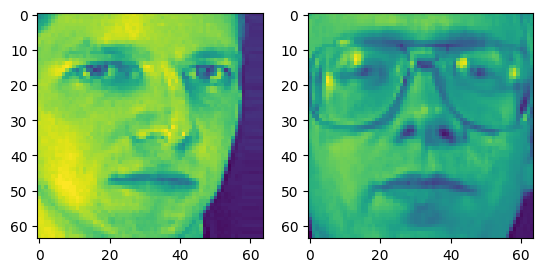

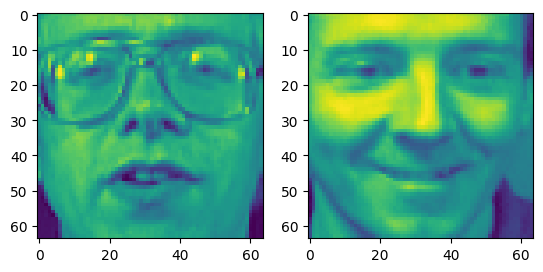

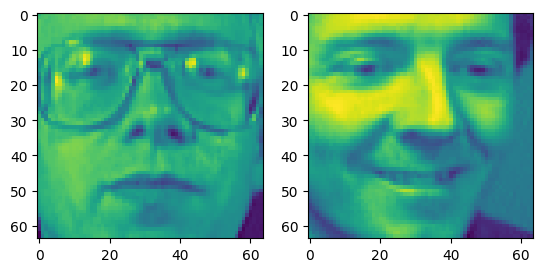

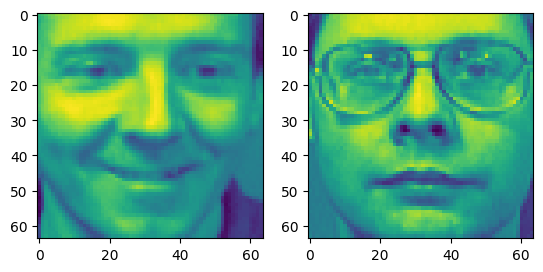

In [ ]:
# Generating the negative pair

for i in range(5):
  plt.subplot(1,2,1)
  plt.imshow(Negative_images[i][0])
  plt.subplot(1,2,2)
  plt.imshow(Negative_images[i][1])
  plt.show()

#### **You should look for generating the test and train pairs from the above two image pairs**

In [ ]:
# Selecting train samples
train_positive = Positive_images[:60]
train_negative = Negative_images[:58]
train_pairs = np.concatenate((train_positive, train_negative), axis=0)

# Selecting test samples
test_positive = Positive_images[60:]
test_negative = Negative_images[58:]
test_pairs = np.concatenate((test_positive, test_negative), axis=0)


In [ ]:
train_pairs.shape

(118, 2, 64, 64)

In [ ]:
test_pairs.shape

(40, 2, 64, 64)

In [ ]:
# Create labels for train pairs (1 for positive, 0 for negative)
train_labels = np.zeros(118)
train_labels[:60] = 1

# Create labels for test pairs (1 for positive, 0 for negative)
test_labels = np.zeros(40)
test_labels[:20] = 1


In [ ]:
train_labels.shape

(118,)

In [ ]:
siamese_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
siamese_model.fit([train_pairs[:,0,:,:],train_pairs[:,1,:,:]],
          train_labels,
          validation_data=([test_pairs[:,0,:,:],
                           test_pairs[:,1,:,:]],
          test_labels),
          epochs=150,
          batch_size=64)

Epoch 1/150
2/2 [==============================] - 4s 423ms/step - loss: 0.7153 - accuracy: 0.4915 - val_loss: 0.6877 - val_accuracy: 0.5000
Epoch 2/150
2/2 [==============================] - 0s 178ms/step - loss: 0.6945 - accuracy: 0.4915 - val_loss: 0.6742 - val_accuracy: 0.5000
Epoch 3/150
2/2 [==============================] - 0s 142ms/step - loss: 0.6839 - accuracy: 0.4915 - val_loss: 0.6365 - val_accuracy: 0.5000
Epoch 4/150
2/2 [==============================] - 0s 147ms/step - loss: 0.6837 - accuracy: 0.4915 - val_loss: 0.6084 - val_accuracy: 0.5000
Epoch 5/150
2/2 [==============================] - 0s 139ms/step - loss: 0.6629 - accuracy: 0.4915 - val_loss: 0.6319 - val_accuracy: 0.5250
Epoch 6/150
2/2 [==============================] - 0s 148ms/step - loss: 0.6614 - accuracy: 0.4915 - val_loss: 0.6521 - val_accuracy: 0.5000
Epoch 7/150
2/2 [==============================] - 0s 145ms/step - loss: 0.6448 - accuracy: 0.4915 - val_loss: 0.6193 - val_accuracy: 0.5000
Epoch 8/150
2

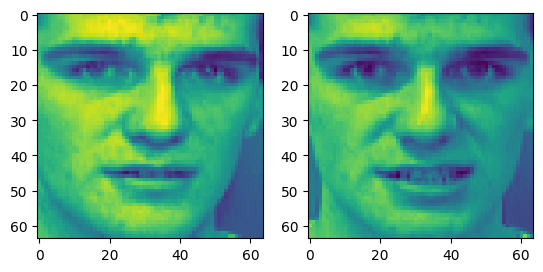

In [ ]:
plt.subplot(1,2,1)
plt.imshow(train_pairs[58][0])
plt.subplot(1,2,2)
plt.imshow(train_pairs[58][1])
plt.show()

In [ ]:
print(train_labels[58])

1.0


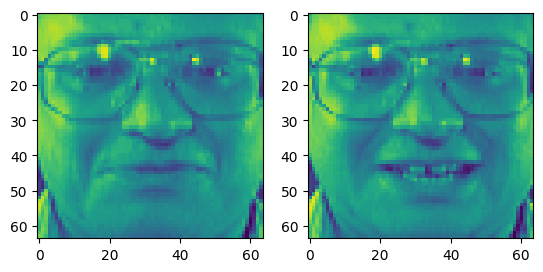

In [ ]:
plt.subplot(1,2,1)
plt.imshow(test_pairs[1][0])
plt.subplot(1,2,2)
plt.imshow(test_pairs[1][1])
plt.show()

In [ ]:
print(test_labels[1])

1.0


In [ ]:
print((siamese_model.predict([test_pairs[1][0].reshape((1,64,64)),test_pairs[1][1].reshape((1,64,64))])).flatten()[0])

1/1 [==============================] - 0s 148ms/step
0.36418107


In [ ]:
count=0
for i in range(118):
  img_A=train_pairs[i][0]
  img_B=train_pairs[i][1]
  if((siamese_model.predict([img_A.reshape((1,64,64)),
                img_B.reshape((1,64,64))]).flatten()[0]>0.5)==True):
    # print(siamese_model.predict([img_A.reshape((1,64,64)),
    #           img_B.reshape((1,64,64))]).flatten()[0],i)
    print(i)
    count+=1
print(count)

1/1 [==============================] - 0s 22ms/step
0
1/1 [==============================] - 0s 19ms/step
2
1/1 [==============================] - 0s 21ms/step
3
1/1 [==============================] - 0s 20ms/step
4
1/1 [==============================] - 0s 21ms/step
5
1/1 [==============================] - 0s 19ms/step
8
1/1 [==============================] - 0s 20ms/step
10
1/1 [==============================] - 0s 23ms/step
15
1/1 [==============================] - 0s 20ms/step
16
1/1 [==============================] - 0s 19ms/step
18
1/1 [==============================] - 0s 23ms/step
19
1/1 [==============================] - 0s 20ms/step
22
1/1 [==============================] - 0s 19ms/step
23
1/1 [==============================] - 0s 19ms/step
24
1/1 [==============================] - 0s 19ms/step
26
1/1 [==============================] - 0s 19ms/step
28
1/1 [==============================] - 0s 20ms/step
29
1/1 [==============================] - 0s 22ms/step
34
1/1 [===========

In [ ]:
count=0
for i in range(40):
  img_A=test_pairs[i][0]
  img_B=test_pairs[i][1]
  if((siamese_model.predict([img_A.reshape((1,64,64)),
                img_B.reshape((1,64,64))]).flatten()[0]>0.5)==True):
    # print(siamese_model.predict([img_A.reshape((1,64,64)),
    #           img_B.reshape((1,64,64))]).flatten()[0],i)
    print(i)
    count+=1
print(count)

1/1 [==============================] - 0s 39ms/step
4
1/1 [==============================] - 0s 30ms/step
10
1/1 [==============================] - 0s 21ms/step
17
1/1 [==============================] - 0s 19ms/step
3
